In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment

%matplotlib inline

In [2]:
#Define some ad-hoc merging, splitting and mixing functions

def ma_A(n_squares):
    A=[]
    for k in range(n_squares):
        
        i = k % int(np.sqrt(n_squares))
        j = k / int(np.sqrt(n_squares))
        ii = []
        jj = []
        if(i>0):
            ii.append(i-1)
        if(i<np.sqrt(n_squares)-1):
            ii.append(i+1)
        if(j>0):
            jj.append(j-1)
        if(j<np.sqrt(n_squares)-1):
            jj.append(j+1)
        for iii in ii:
            a = np.zeros(n_squares)
            a[k] = 1
            kk = iii + int(np.sqrt(n_squares))*j
            
            a[kk] = -1
            A.append(a)
        for jjj in jj:
            a = np.zeros(n_squares)
            a[k] = 1
            kk = i + int(np.sqrt(n_squares))*jjj
            a[kk] = -1
            A.append(a)
    return np.array(A)

def batch_split(batch, n_squares_side, n_channels=1):
    
    side = int(np.sqrt(batch.shape[1]))
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    print(np.sqrt(batch.shape[2]/n_channels))
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    return side, side_square

def resize_batch(batch, side_new):
    batch_new = np.zeros((batch.shape[0], side_new **2))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        a = imresize(np.reshape(batch[i,:], [side,side]), [side_new, side_new])
        a = a.flatten()
        a = a/255.0
        batch_new[i,:] = a.flatten()
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


In [3]:
#Define model params
batch_size = 10
n_iter = 1000
samples_per_num = 1
n_iter_sinkhorn = 20
noise_factor = 1.0
keep_prob =1.0
opt = 'sgd'
n_units = 32
temp = 0.1
lr = 0.1

#mnist data
rfield_size = 5
n_squares_side = 3
n_channels = 1
stride = 1
n_squares = n_squares_side **2
n_dim = 5
side, side_square = resized_dims(n_squares_side)


In [4]:
#Main neural network definitions

def create_log_alpha():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(0.0))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool =tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image):
        with tf.variable_scope("conv1"):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output = dropout(tf.cast(fc(flatten(conv_output), n_dim, activation_fn = None), tf.float32),
                                        keep_prob)
        return fully_connected_output
    
    with tf.variable_scope("model_params"):
        X = tf.math.l2_normalize(tf.reshape(conv_and_fc(stack_scrambled_images_split), [-1, n_squares, n_dim]))
        #X = tf.reshape(conv_and_fc(stack_scrambled_images_split), [-1, n_squares, n_dim])
        
        log_alpha = tf.matmul(X, tf.transpose(X, [0, 2, 1]))/10.0
    return log_alpha

In [5]:
#Now we define the main TF variables

scrambled_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, 1])
scrambled_split_tiled = tf.tile(scrambled_split, [samples_per_num, 1, 1, 1, 1])

stack_scrambled_images_split = tf.placeholder(tf.float32,[None, side_square, side_square, 1])

real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, 1])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])


temperature = tf.constant(temp, dtype=tf.float32)
global_step = tf.Variable(0, trainable=False)
fc = tf.contrib.layers.fully_connected
AA = tf.cast(tf.tile(tf.constant(np.matmul(ma_A(n_squares).T, ma_A(n_squares)))[np.newaxis,:,:],[batch_size, 1, 1]), tf.float32)

log_alpha = create_log_alpha()
soft_perms_inf = tf.cast(tf.tile(tf.constant(np.eye(n_squares))[np.newaxis,:,:],[batch_size, 1, 1]), tf.float32)
tau=tf.constant(1./temp,dtype=tf.float32)
for _ in range(10):
    P = tf.reshape(soft_perms_inf, [-1, n_squares, n_squares])
    #ma = tf.matmul(-tau*AA, tf.matmul(P, log_alpha))
    ma = tf.matmul(-AA, tf.matmul(P, log_alpha))
    
    (soft_perms_inf, _) = sinkhorn_ops.gumbel_sinkhorn(ma, temp, samples_per_num,
                                                                       noise_factor, n_iter_sinkhorn, squeeze=False)

inv_soft_perms = tf.transpose(soft_perms_inf, [0, 1, 3, 2])
inv_soft_perms_flat = tf.reshape( tf.transpose(inv_soft_perms, [1, 0, 2, 3]), [-1, n_squares, n_squares])

real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2 * n_channels])
scrambled_split_tiled = tf.reshape(scrambled_split_tiled, [-1, n_squares, side_square ** 2* n_channels])
ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)
l2s_diff = tf.reduce_mean(tf.square(real_split_tiled - ordered_inf))
opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
#Lets train the model
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)

for i in range(n_iter):
    np_x,np_y=data_train.next_batch(batch_size)
    np_x = resize_batch(np_x, side)

    real_images_split = batch_split(np_x, n_squares_side)
    scrambled_images_split = np.zeros(real_images_split.shape)
    
    for j in range(batch_size):
        perm = np.random.permutation(n_squares)
        scrambled_images_split[j,:, :, :] = real_images_split[j, perm, :, :]
    stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
    _,loss=sess.run([train_op,l2s_diff],{real_split:real_images_split,
                                         scrambled_split:scrambled_images_split,
                                        stack_scrambled_images_split:stacked_scrambled_images_split})
    
   
    if i % 50 == 1:
        print('Step %d, Loss: %0.7f' % (i,loss))


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Step 1, Loss: 0.1345430
Step 51, Loss: 0.1229140
Step 101, Loss: 0.1097049
Step 151, Loss: 0.1126298
Step 201, Loss: 0.1278457
Step 251, Loss: 0.1247047
Step 301, Loss: 0.1266059
Step 351, Loss: 0.1155406
Step 401, Loss: 0.1172459
Step 451, Loss: 0.1453274
Step 501, Loss: 0.1176950
Step 551, Loss: 0.1223876
Step 601, Loss: 0.1332524
Step 651, Loss: 0.1158091
Step 701, Loss: 0.1047667
Step 751, Loss: 0.1170883
Step 801, Loss: 0.1129162
Step 851, Loss: 0.1140345
Step 901, Loss: 0.1324611
Step 951, Loss: 0.1434383


In [7]:
#Now let's test the model
batch_size_test=10
np_x,np_y=data_test.next_batch(batch_size_test)
np_x = resize_batch(np_x, side)
real_images_split = batch_split(np_x, n_squares_side)
scrambled_images_split = np.zeros(real_images_split.shape)
    
for i in range(batch_size_test):
    perm = np.random.permutation(n_squares)
    scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
[unscrambled_images,loss, inv_soft_perms_np,ma_np, log_alpha_np] = sess.run([ordered_inf,l2s_diff, inv_soft_perms,ma, log_alpha],{real_split:real_images_split,
                            scrambled_split:scrambled_images_split,
                            stack_scrambled_images_split:stacked_scrambled_images_split})
unscrambled_images = unscrambled_images[:batch_size_test,:,:]
inv_hard_perms= np.zeros((batch_size_test, n_squares, n_squares))
for i in range(batch_size_test):
    inv_hard_perms[i,:,:] = soft_to_hard(inv_soft_perms_np[i,0,:,:])
unflatten_inf = unflatten_batch(unscrambled_images)
hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split, [batch_size_test,n_squares_side **2 ,-1]))
unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
joined_hard_inf =join_batch_split(unflatten_hard_inf)
joined_inf = join_batch_split(unflatten_inf)
joined_scrambled = join_batch_split(scrambled_images_split)
joined_real = join_batch_split(real_images_split)

/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


9.0


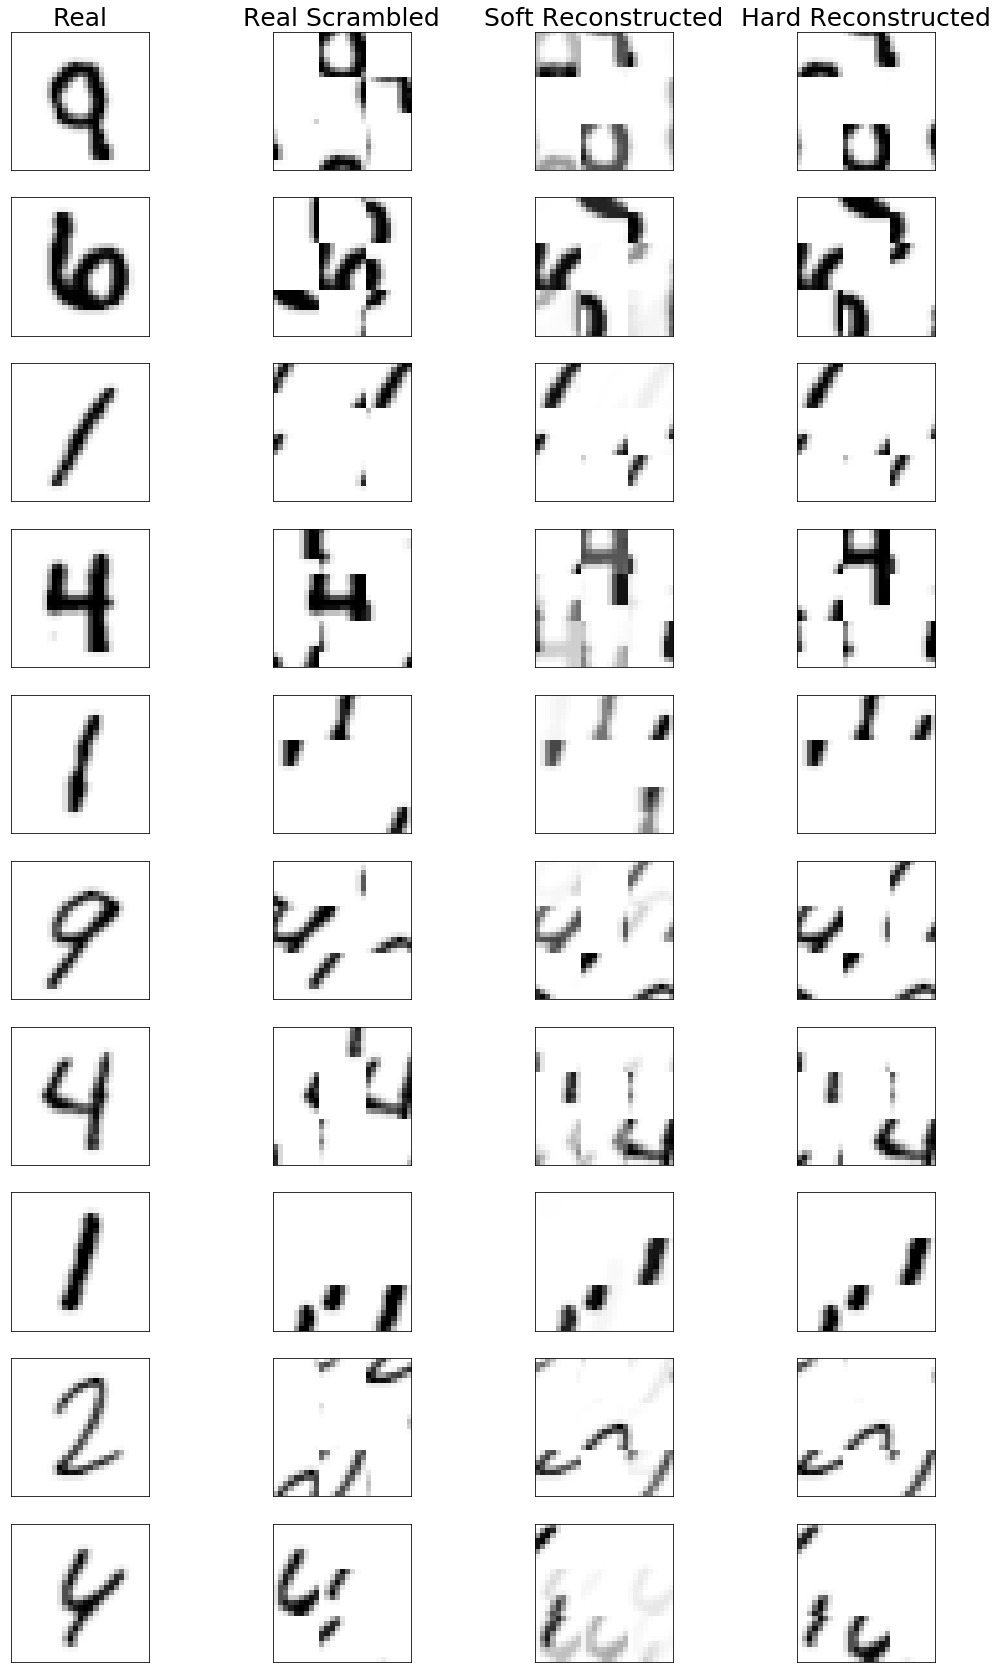

In [8]:
#Compare reconstructions with real data
fig, ax = plt.subplots(batch_size_test,4,figsize=(18,30))

for i in range(batch_size_test):
   
    ax[i,0].imshow(joined_real[i,:,:,0],cmap='Greys')
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    ax[i,1].imshow(joined_scrambled[i,:,:,0],cmap='Greys')
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    ax[i,2].imshow(joined_inf[i,:,:,0],cmap='Greys')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
    
    ax[i,2].imshow(joined_inf[i,:,:,0],cmap='Greys')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
   
    ax[i,3].imshow(joined_hard_inf[i,:,:,0],cmap='Greys')
    ax[i,3].get_xaxis().set_visible(False)
    ax[i,3].get_yaxis().set_visible(False)
   

    if(i==0):
        ax[i,0].set_title('Real',fontsize =25)
        ax[i,1].set_title('Real Scrambled',fontsize =25)
        ax[i,2].set_title('Soft Reconstructed',fontsize =25)
        ax[i,3].set_title('Hard Reconstructed',fontsize =25)

(10, 9, 81)


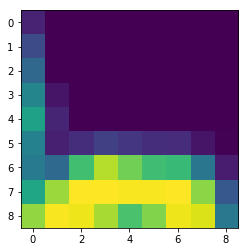

In [9]:
print(unscrambled_images.shape)
plt.imshow(np.reshape(unscrambled_images[0,6,:], [9,9]))

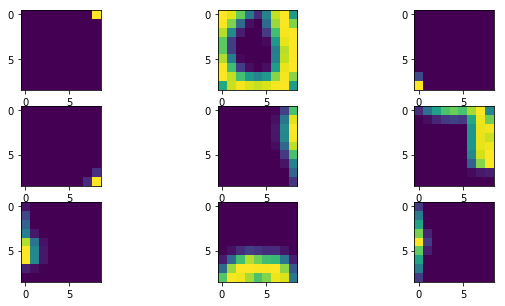

In [10]:
fix, ax =plt.subplots(3,3,figsize=(10,5))
ax=ax.flatten()
for i in range(9):
    ax[i].imshow(scrambled_images_split[0,i,:,:,0])

In [11]:
s=np.reshape(scrambled_images_split, [batch_size_test, n_squares, -1])

(10, 1, 9, 9)
[1.1332964  1.1262511  0.9996636  0.8282085  0.9252966  0.75770897
 1.1143792  1.0949731  1.0202228 ]
[[ 4.0536100e-04  2.8900389e-05  2.7706460e-04 -6.5847431e-08
   3.3742838e-04  2.0514293e-04  8.3642814e-04  2.3953561e-04
   3.1652494e-04]
 [ 2.8900389e-05  1.8891078e-05  9.9567151e-06 -2.6666513e-08
   8.1446422e-05  6.9957416e-05  3.8758288e-05 -9.1673819e-06
   2.9468676e-05]
 [ 2.7706460e-04  9.9567151e-06  4.2964732e-03 -3.2752601e-07
   2.8532988e-03  1.4996054e-03 -1.4520891e-03  6.1888929e-04
  -1.7923627e-03]
 [-6.5847431e-08 -2.6666513e-08 -3.2752601e-07  6.1696717e-11
  -3.4215125e-07 -2.1319013e-07  2.0744938e-08 -3.7108926e-08
   9.1720047e-08]
 [ 3.3742838e-04  8.1446422e-05  2.8532988e-03 -3.4215125e-07
   3.0685156e-03  1.3987671e-03 -5.6753495e-05  4.5154366e-04
  -1.1170751e-03]
 [ 2.0514293e-04  6.9957416e-05  1.4996054e-03 -2.1319013e-07
   1.3987671e-03  8.1062398e-04 -2.2191470e-04  1.8871923e-04
  -5.5366330e-04]
 [ 8.3642814e-04  3.8758288e-05 

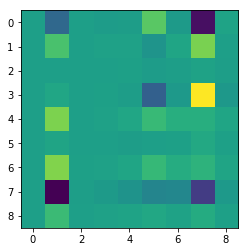

In [12]:
print(inv_soft_perms_np.shape)
plt.imshow(inv_soft_perms_np[1,0,:,:])
print(np.sum(inv_soft_perms_np[0,0,:,:], axis=0))
plt.imshow(ma_np[0,:,:])
print(log_alpha_np[1,:,:])
print(inv_soft_perms_np[1,0,:,:])
print(ma_np[0,:,:])

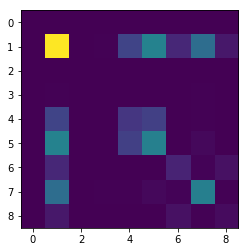

In [13]:
plt.imshow(np.matmul(s, np.transpose(s, [0,2,1]))[0,:,:])

In [14]:
def ma_A(n_squares):
    A=[]
    for k in range(n_squares):
        
        i = k % int(np.sqrt(n_squares))
        j = k / int(np.sqrt(n_squares))
        ii = []
        jj = []
        if(i>0):
            ii.append(i-1)
        if(i<np.sqrt(n_squares)-1):
            ii.append(i+1)
        if(j>0):
            jj.append(j-1)
        if(j<np.sqrt(n_squares)-1):
            jj.append(j+1)
        for iii in ii:
            a = np.zeros(n_squares)
            a[k] = 1
            kk = iii + int(np.sqrt(n_squares))*j
            
            a[kk] = -1
            A.append(a)
        for jjj in jj:
            a = np.zeros(n_squares)
            a[k] = 1
            kk = i + int(np.sqrt(n_squares))*jjj
            a[kk] = -1
            A.append(a)
    return np.array(A)

In [15]:
AA = np.matmul(ma_A(n_squares).T, ma_A(n_squares))
P = np.eye(n_squares)
XX = np.matmul(s, np.transpose(s, [0,2,1]))[0,:,:]
tau=0.5
for p in range(100):
    P=sinkhorn(np.matmul(AA, np.matmul(P, XX))/0.1)

NameError: name 'sinkhorn' is not defined

In [ ]:
plt.imshow(P)
print(s.shape)

In [ ]:
def sinkhorn(K,  n_iter=20, mu_x=None,mu_y=None,type=None):
  if (mu_x is None):
    mu_x = np.ones(K.shape[0])/K.shape[0]
  if(mu_y is None):
    mu_y = np.ones(K.shape[1])/K.shape[1]
  if(type is not None):
    v = np.random.uniform(0, 1, len(mu_y))
  else:
    v = np.ones(len(mu_y))
  #
  u = np.ones(len(mu_x))
  u = np.random.uniform(0, 1, len(mu_x))
  K_exp = np.exp(-1 * K)

  for _ in range(n_iter):

    u = np.divide(mu_x, np.dot(K_exp, v))
    v = np.divide(mu_y, np.dot(K_exp.T, u))
  u = np.divide(mu_x, np.dot(K_exp, v))
  b=np.dot(np.diag(u), np.dot(K_exp, np.diag(v)))
  
  return b

In [ ]:
print(temp)